# Explanation of results

In [1]:
import sys  
sys.path.insert(0, "/home/arx7ti/code/python/cold-nilm")

In [2]:
test_log = {
    "f1_shoewarmer":  39.31,
    "f1_solderingiron":  41.44,
    "f1_mosquitorepellent":  44.24,
    "f1_halogen":  49.54,
    "f1_fan":  51.50,
    "f1_networkswitch":  58.69,
    "f1_ac":  58.69,
    "f1_cablemodem":  58.79,
    "f1_lightbulb":  60.93,
    "f1_charger":  64.19,
    "f1_fridge":  68.34,
    "f1_powersupply":  74.61,
    "f1_ledlight":  75.11,
    "f1_gameconsole":  75.26,
    "f1_laserprinter":  75.97,
    "f1_cablereceiver":  76.38,
    "f1_laptop":  76.80,
    "f1_cfl":  77.80,
    "f1_guitaramp":  78.86,
    "f1_toaster":  80.10,
    "f1_hairdryer":  80.30,
    "f1_jigsaw":  80.52,
    "f1_heater":  81.77,
    "f1_kitchenhood":  83.50,
    "f1_washingmachine":  83.84,
    "f1_tv":  84.48,
    "f1_mixer":  84.79,
    "f1_multitool":  87.24,
    "f1_vacuumcleaner":  87.38,
    "f1_drillingmachine":  87.41,
    "f1_iron":  88.27,
    "f1_kettle":  88.33,
    "f1_coffeemachine":  88.65,
    "f1_flatiron":  89.03,
    "f1_ricecooker":  89.69,
    "f1_massage":  89.85,
    "f1_monitor":  89.86,
    "f1_hifi":  90.78,
    "f1_halogenfluter":  91.64,
    "f1_desktoppc":  92.89,
    "f1_shredder":  94.44,
    "f1_microwave":  95.67,
    "f1_juicemaker":  96.50,
    "f1_waterheater":  96.96,
    "f1_sewingmachine":  97.00,
    "f1_sandwichmaker":  97.24,
    "f1_benchgrinder":  97.35,
    "f1_desoldering":  98.19,
    "f1_projector":  99.02,
    "f1_deepfryer":  99.03,
    "f1_stove":  99.42,
    "f1_waterpump":  99.59,
    "f1_treadmill":  99.68,
    "f1_fanheater":  99.76,
}

In [3]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from source.synthesizer import drop_empty_categories, parse_magnitude 

In [4]:
import seaborn as sb
import matplotlib.pyplot as plt
from beartype import beartype
from typing import Dict, List

In [5]:
sb.set()

### Toolbox

In [6]:
@beartype
def _rms(array: np.ndarray) -> float:
    """
    Arguments:
        array: np.ndarray
    Returns:
        float 
    """
    return np.sqrt(np.sum(array**2)/len(array))


@beartype
def describe(
    patterns: Dict[str, Dict[str, List[np.ndarray]]],
    fundamental: int = 50, 
    sampling_rate: int = 4000, 
    sort_by: str = "c_rms_mean"
) -> pd.DataFrame:
    """
    Arguments:
        patterns: Dict[str, Dict[str, List[np.ndarray]]]
        fundamental: int 
        sampling_rate: int 
        sort_by: str
    Returns:
        pd.DataFrame 
    """

    data = {"label": [], "count": [], "t_mean": [], "v_f_mean": [],
            "v_rms_mean": [], "v_st_mean": [], "v_max_mean": [],
            "c_rms_mean": [], "c_max_mean": []}

    for label, channels in tqdm(patterns.items()):
        currents, voltages = channels["current"], channels["voltage"]
        # Per signal duration
        t = []
        # Voltage frequencies
        v_f = []
        # Voltage RMS values
        v_rms = []
        # Voltage steady state magnitudes
        v_st = []
        # Voltage absolute maximum values
        v_max = []
        # Current RMS values
        c_rms = []
        # Current absolute maximum values
        c_max = []
        for idx, (voltage, current) in enumerate(zip(voltages, currents)):
            v_freqs = np.fft.rfftfreq(len(voltage), 1/sampling_rate)
            t.append(len(voltage)/sampling_rate)
            v_f.append(v_freqs[np.argmax(np.abs(np.fft.rfft(voltage)))])
            v_rms.append(_rms(voltage))
            v_st.append(parse_magnitude(voltage, fundamental, sampling_rate))
            v_max.append(np.max(np.abs(voltage)))
            c_rms.append(_rms(current))
            c_max.append(np.max(np.abs(current)))

        data["label"].append(label)
        data["count"].append(len(voltages))
        data["t_mean"].append(np.mean(t))
        data["v_f_mean"].append(np.mean(v_f))
        data["v_rms_mean"].append(np.mean(v_rms))
        data["v_st_mean"].append(np.mean(v_st))
        data["v_max_mean"].append(np.mean(v_max))
        data["c_rms_mean"].append(np.mean(c_rms))
        data["c_max_mean"].append(np.mean(c_max))

    table = pd.DataFrame(data)

    return table.sort_values(by=sort_by)

### Statistics per category of appliances

In [7]:
patterns = np.load("../experiments/synthetic/patterns-7625091cfc792e6c13402b3bace0103a.npy", allow_pickle=True).item()

In [8]:
drop_empty_categories(patterns, 5, True, True)
df = describe(patterns, fundamental=50, sampling_rate=4000)
df

  0%|          | 0/54 [00:00<?, ?it/s]

,label,count,t_mean,v_f_mean,v_rms_mean,v_st_mean,v_max_mean,c_rms_mean,c_max_mean
29,networkswitch,9,5.000000,50.0,221.364588,311.007616,311.535889,0.033662,2.530730
52,cablemodem,8,5.000000,50.0,221.385118,310.985283,311.503326,0.043399,2.713334
18,mosquitorepellent,8,4.987500,50.0,223.714225,311.000000,311.878906,0.056172,0.332626
9,cablereceiver,10,5.000000,50.0,221.312866,311.010162,311.703308,0.068673,1.929983
41,shoewarmer,19,4.961053,50.0,223.340156,311.000005,311.994415,0.102665,0.359886
43,cfl,139,2.791799,50.0,220.445520,311.029443,314.088593,0.109560,2.516876
19,charger,62,4.968710,50.0,222.447375,311.000002,312.050781,0.110403,2.137782
14,halogen,10,4.962000,50.0,217.646787,311.000000,311.509216,0.110860,0.494057
15,gameconsole,33,4.961818,50.0,223.357168,310.999996,311.797668,0.145837,0.611084
1,massage,28,4.952857,50.0,221.644175,311.000001,312.334045,0.153967,0.950511


In [9]:
# Select F1-values for top10 appliances with lower RMS current
f1_values = {k[3:]: v/100 for k, v in test_log.items() if k.startswith(
    "f1_") and k[3:] in df.iloc[:10]["label"].values}
f1_values

{'shoewarmer': 0.3931,
 'mosquitorepellent': 0.4424,
 'halogen': 0.4954,
 'networkswitch': 0.5869,
 'cablemodem': 0.5879,
 'charger': 0.6419,
 'gameconsole': 0.7526,
 'cablereceiver': 0.7637999999999999,
 'cfl': 0.778,
 'massage': 0.8985}

### Plot 

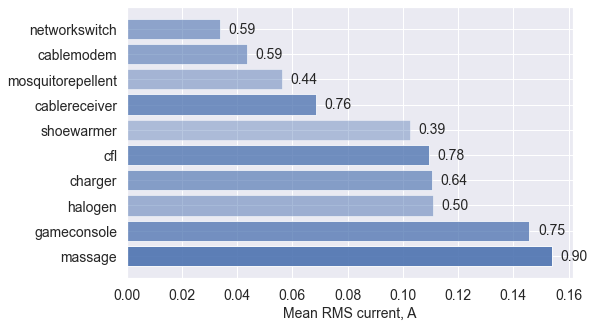

In [10]:
# Plot appliances
mask = df["label"].isin(df.iloc[:10]["label"])
plt.figure(figsize=(8, 5))
bins = plt.barh(df[mask]["label"].iloc[::-1], df[mask]
                ["c_rms_mean"].iloc[::-1])
# Bind F1-scores
for i, label in enumerate(df[mask].label.iloc[::-1].values):
    bins[i].set_alpha(f1_values[label])
    height = bins[i].get_height()
    width = bins[i].get_width()
    plt.text(width+0.008, bins[i].get_y() + bins[i].get_height()/2,
             "%.2f" % f1_values[label],
             ha="center", va="center", rotation=0, fontsize=14)
plt.xlabel("Mean RMS current, A", fontsize=14)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.savefig("top10.png", bbox_inches="tight")
plt.show()

### Visual comparison of signatures

In [16]:
random_seed = 42

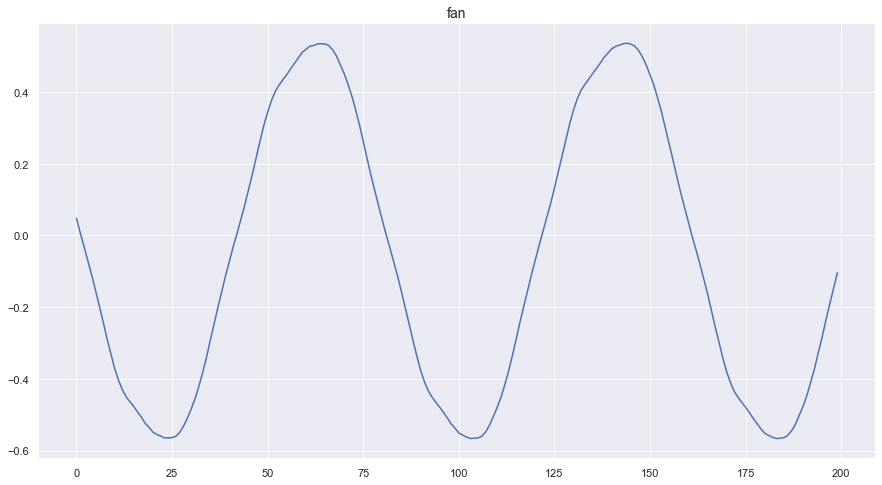

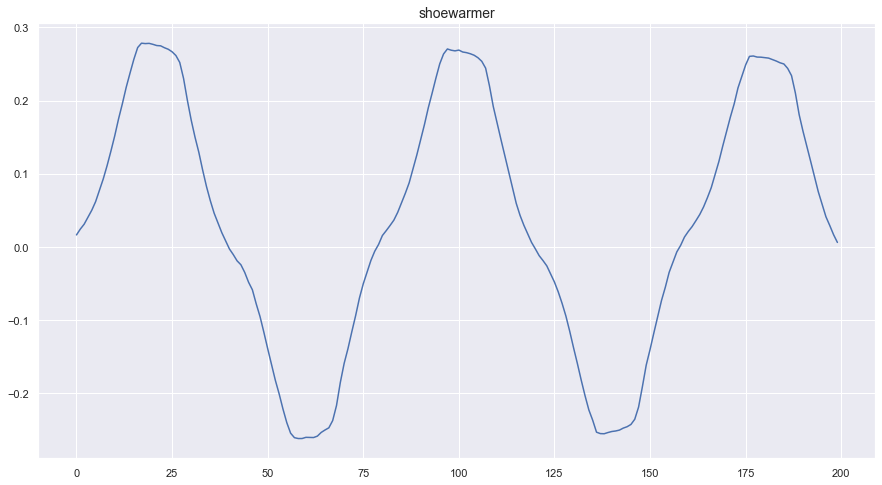

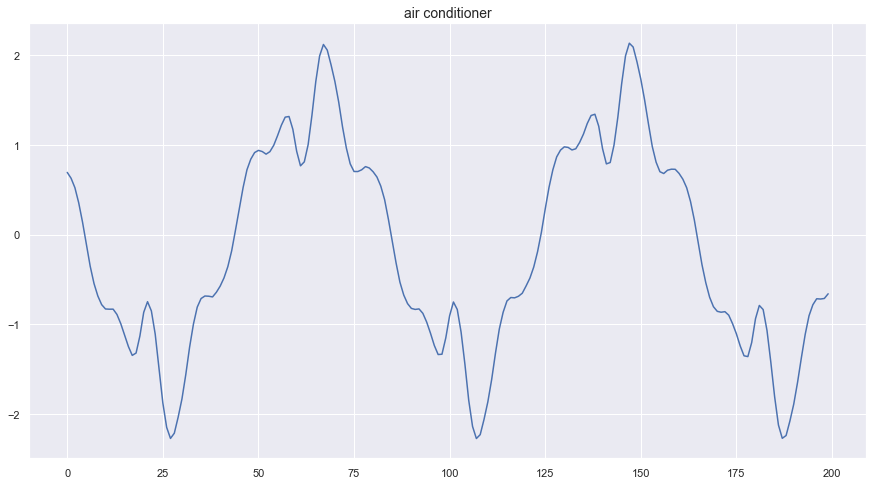

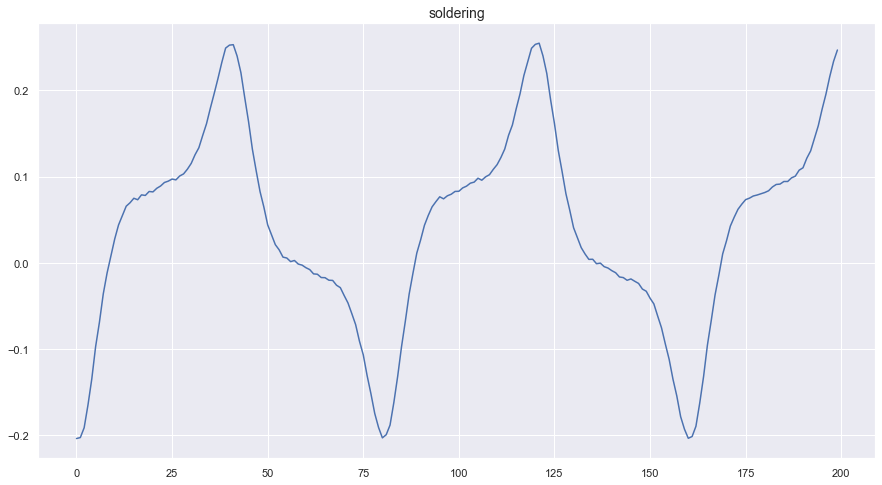

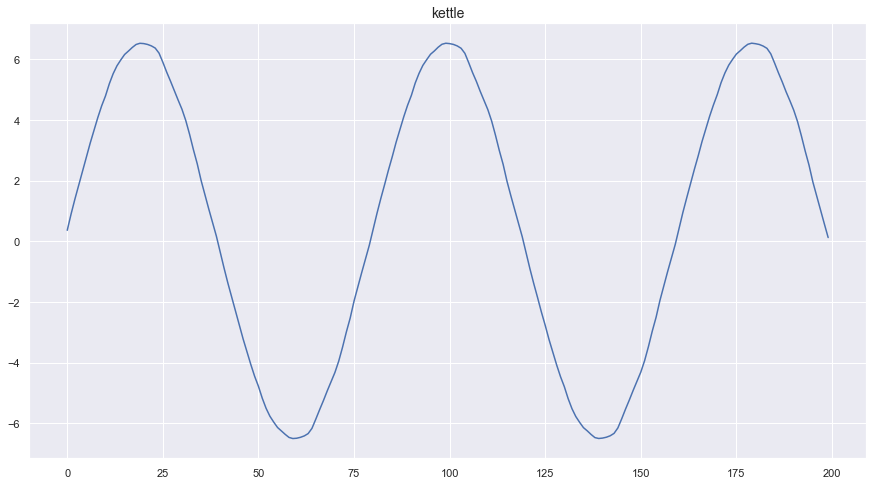

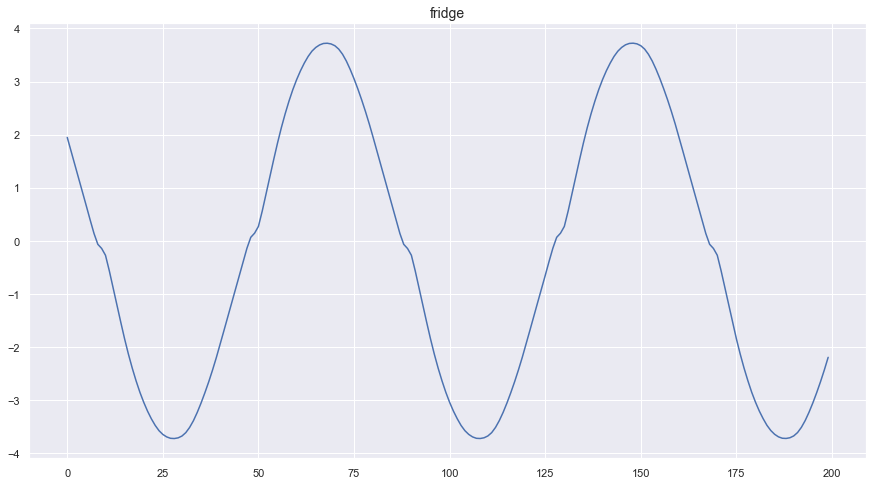

In [17]:
fan = patterns["fan"]["current"]
shoewarmer = patterns["shoewarmer"]["current"]
ac = patterns["ac"]["current"]
soldering = patterns["solderingiron"]["current"]
kettle = patterns["kettle"]["current"]
fridge = patterns["fridge"]["current"]

np.random.seed(random_seed)
i = np.random.randint(min(len(fan), len(shoewarmer),
                      len(ac), len(soldering), len(kettle), len(fridge)))

plt.figure(figsize=(15, 8))
plt.plot(fan[i][2000:2200])
plt.title("fan", fontsize=14)
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(shoewarmer[i][2000:2200])
plt.title("shoewarmer", fontsize=14)
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(ac[i][2000:2200])
plt.title("air conditioner", fontsize=14)
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(soldering[i][2000:2200])
plt.title("soldering", fontsize=14)
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(kettle[i][2000:2200])
plt.title("kettle", fontsize=14)
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(fridge[i][2000:2200])
plt.title("fridge", fontsize=14)
plt.show()